In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import IndexSlice as ix

import torch
import torch.nn as nn
import yfinance

In [2]:
TARGET = "N225"
TICKERS = {
    "^N225": "Nikkei 225",
    "^GSPC": "S&P 500",
    "^TNX": "US10Y Interest Rate",
    "DX-Y.NYB": "ICE Dollar Index",
    # VIX
}

# Data

In [3]:
# Get Daily OHLC from YFinance
from cqf.data.yfinance import get_daily_ohlc
ohlc = pd.concat([get_daily_ohlc(ticker) for ticker in TICKERS])

display(
    "Table1: Feature Tickers List",
    pd.DataFrame([TICKERS]).T.reset_index().set_axis(["YFinance Ticker", "Name"], axis=1),
    
    "Table2: Raw Data Periods",
    ohlc.reset_index().groupby("ticker").date.agg(["min", "max", "count"]).rename(TICKERS)
)

'Table1: Feature Tickers List'

,YFinance Ticker,Name
0,^N225,Nikkei 225
1,^GSPC,S&P 500
2,^TNX,US10Y Interest Rate
3,DX-Y.NYB,ICE Dollar Index


'Table2: Raw Data Periods'

,min,max,count
ticker,,,
ICE Dollar Index,2010-01-04,2023-12-29,3521
S&P 500,2010-01-04,2023-12-29,3522
Nikkei 225,2010-01-04,2023-12-29,3425
US10Y Interest Rate,2010-01-04,2023-12-29,3519


# Features/Labels

- OC
- HL
- HC
- LC
- OS
- V

In [4]:
# calculate features
from cqf.preprocess.feature import calc_ohlcv_features

features = pd.concat([calc_ohlcv_features(ohlc.query("ticker==@ticker")) for ticker in ohlc.ticker.unique()], axis=1)
label_ret = ohlc.query("ticker=='^N225'").assign(oc = lambda x: (x.close-x.open))["oc"].shift(-1).dropna()
label = (label_ret > 0).astype(int)

# To stack format
features_stack = (
    features
    .stack().rename("value").reset_index()
    .assign(
        ticker=lambda x: x.feature.str.split("_").str[-1].replace(TICKERS), 
        feature=lambda x: x.feature.str.split("_").str[0]
    )
    .set_index(["date", "ticker", "feature"]).value.unstack(level=[1, 2])
)

# EDA

## Univariate basic stats

In [5]:
display(
    "Table3: Basic Statistics of Raw Feature Values",
    features_stack.describe().T.style.format(precision=2),
)

'Table3: Basic Statistics of Raw Feature Values'

## Multivariate basic stats

'Fig.1: Scatter Matrix of Features of Nikkei 225'

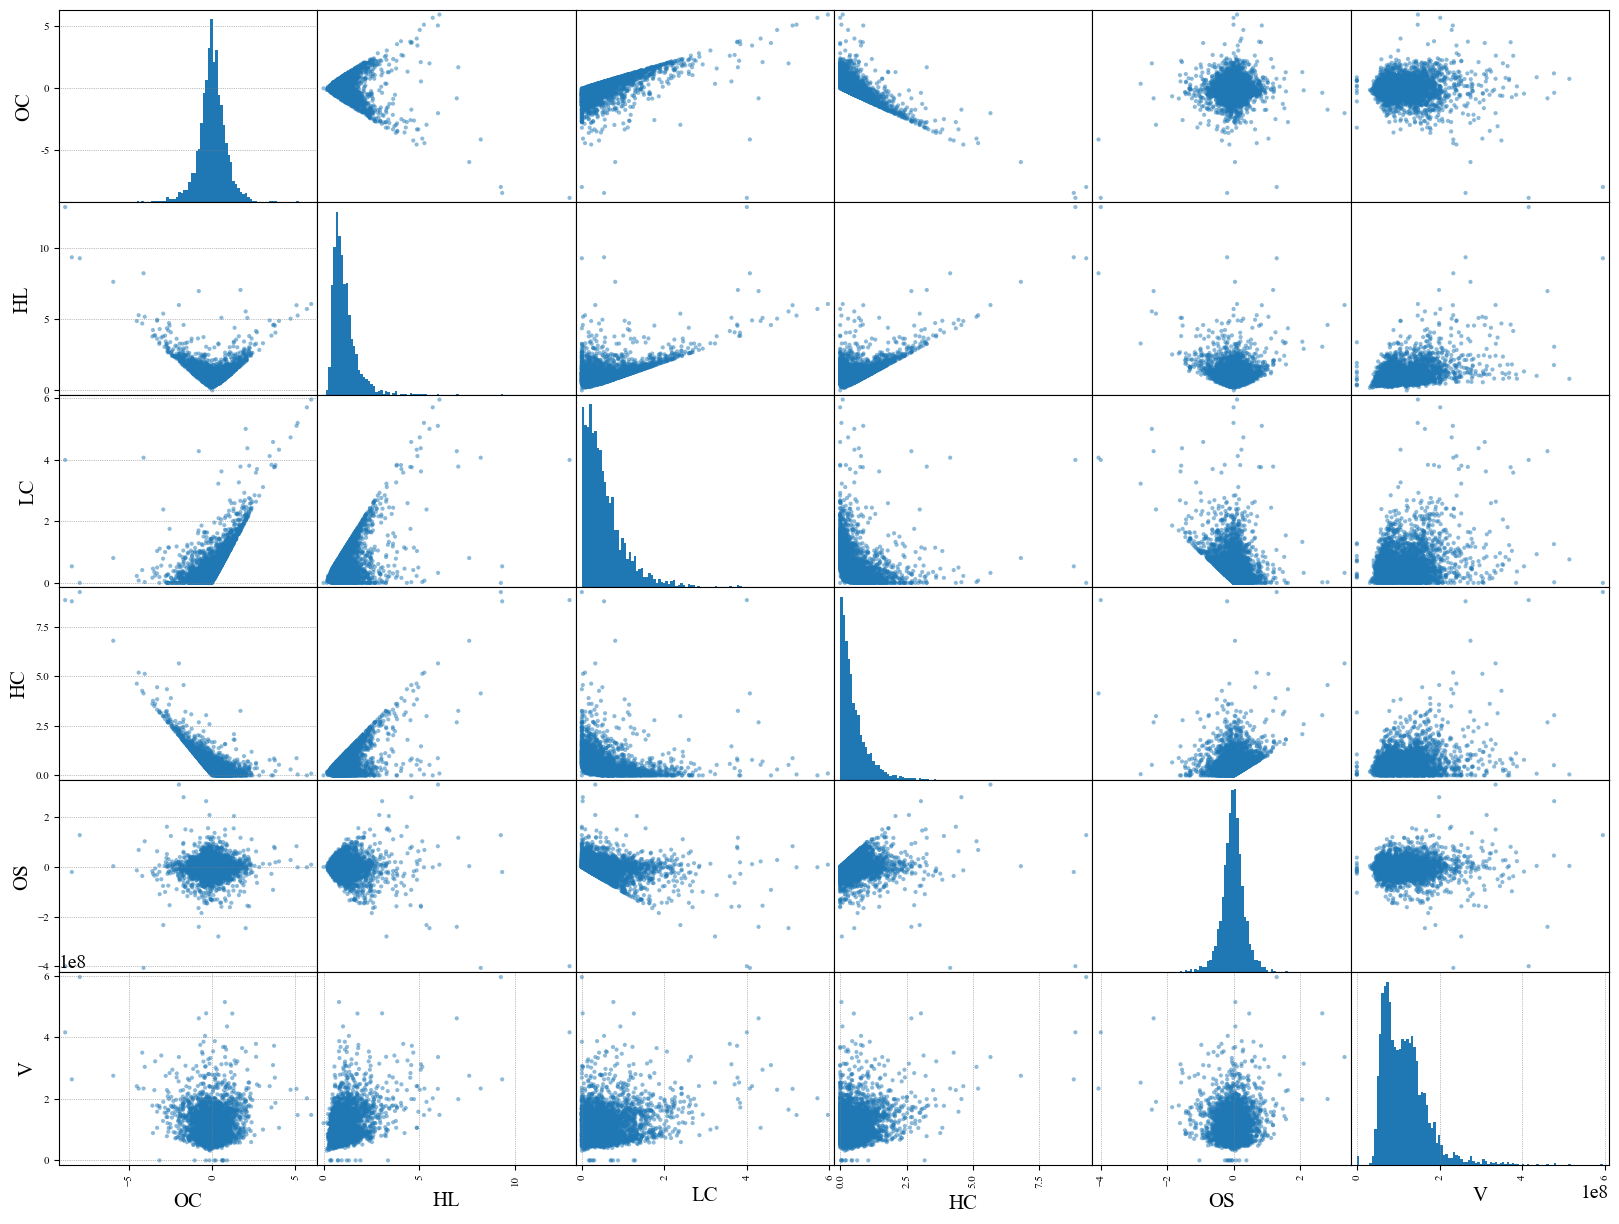

In [6]:
# Scatter matrix
display("Fig.1: Scatter Matrix of Features of Nikkei 225")

features_n225 = features_stack["Nikkei 225"]
pd.plotting.scatter_matrix(features_n225, hist_kwds={"bins": 100}, figsize=(20, 15), grid=True);

In [7]:
# Correlation matrix
display(
    "Fig.2: Correlation Matrix of Raw Feature Values",
    features_stack.corr()
    .replace(1, np.nan).style.format(precision=2).background_gradient(vmin=-1, vmax=1, cmap="RdBu")
)

'Fig.2: Correlation Matrix of Raw Feature Values'

# Feature Transformation

## For bell-form features

- rolling
- deMean, deStd

In [8]:
from cqf.preprocess import apply_rolling_lognormalize1
features1 = apply_rolling_lognormalize1(features_stack.loc[:, ix[:, ["OC", "OS"]]])

## For all positive features

- log(1+f)
- rolling

In [9]:
from cqf.preprocess import apply_rolling_lognormalize2
features2 = apply_rolling_lognormalize2(features_stack.loc[:, ix[:, ["V", "HL"]]])

In [10]:
# from sklearn.preprocessing import PowerTransformer
# log.rolling(window).apply(transform)

In [11]:
# Concatenate
features_norm = pd.concat([features1, features2], axis=1).fillna(0)

# Train

## Train/Test splitting

In [12]:
TRAIN_ST = "2011-01-01"
TRAIN_ET = "2017-12-30"
# VALID_ST = "2017-01-01"
# VALID_ET = "2017-12-30"
TEST_ST = "2018-01-01"
TEST_ET = "2023-12-30"

In [13]:
# Train/test split
y = label
x = features_norm.loc[label.index]

y_train = y.loc[TRAIN_ST:TRAIN_ET]
x_train = x.loc[TRAIN_ST:TRAIN_ET]
y_test = y.loc[TEST_ST:TEST_ET]
x_test = x.loc[TEST_ST:TEST_ET]

In [38]:
# Dataset
from cqf.model.dataset import TimeSeriesDataset1D
from torch.utils.data import DataLoader
n_lookback = 30
train_dataset = TimeSeriesDataset1D(x=x_train, y=y_train, n_lookback=n_lookback)
valid_dataset = TimeSeriesDataset1D(x=x_train, y=y_train, n_lookback=n_lookback, target_months=[3, 6, 9, 12])
test_dataset = TimeSeriesDataset1D(x=x_test, y=y_test, n_lookback=n_lookback)

# DataLoader

train_loader = DataLoader(train_dataset, batch_size=64)
valid_loader = DataLoader(valid_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [39]:
from cqf.utils import set_seed
set_seed(7)

<AxesSubplot:>

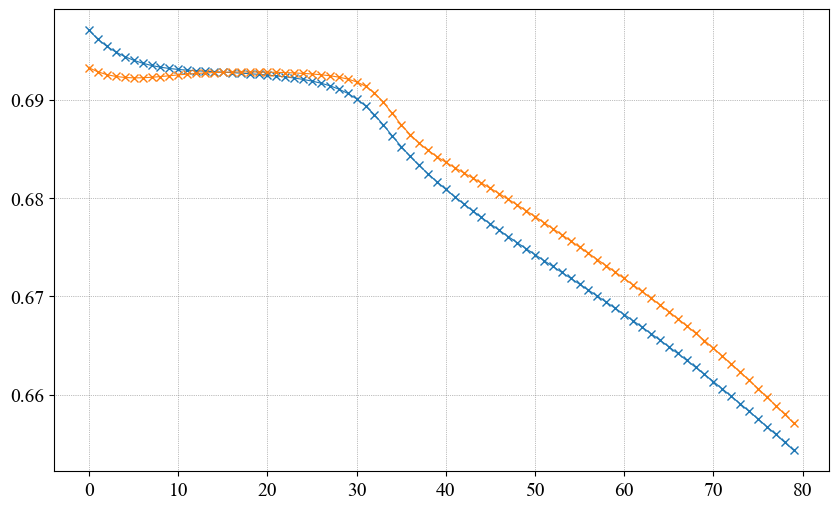

In [40]:
# Model setup
from copy import deepcopy
from cqf.model.lstm import LSTMClassifier
model = LSTMClassifier(
    input_size = x.shape[1],
    hidden_size = 32,
    num_layers = 3,
)

# Loss&Optimizer
criterion = nn.BCELoss()  # 2値分類の場合はnn.BCELoss()を使用することも可能
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training Loop
num_epochs = 80
train_log = []

patience = 30
best_val_loss = np.inf
counter = 0

for epoch in range(num_epochs):
    # Train Loop
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Validation Loop
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # バリデーションセットの性能が改善しない場合のカウンター更新
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        counter = 0
    else:
        counter += 1

    # terminate training loop
    if counter >= patience:
        print(f'Early stopping at epoch {epoch}')
        break
    
    train_log.append({
        "epoch": epoch,
        "train_loss": running_loss / len(train_loader),
        "val_loss": val_loss / len(valid_loader),
    })
    # print(f'Epoch {epoch+1}/{num_epochs}, {train_log[-1]}')
    
pd.DataFrame(train_log).train_loss.plot(marker="x")
pd.DataFrame(train_log).val_loss.plot(marker="x")

In [41]:
# train_loader0 = deepcopy(train_loader)
# test_loader0 = deepcopy(test_loader)

In [42]:
# train_loader1 = deepcopy(train_loader)
# test_loader1 = deepcopy(test_loader)

In [43]:
# test
predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        predictions.append(best_model(inputs).numpy())
predictions = np.concatenate(predictions).reshape(-1,)

pred_test = pd.DataFrame({"t": test_dataset.time_index, "pred": predictions, "label": y_test.values[n_lookback-1:]})
pred_test = pred_test.join(label_ret, on="t")
pred_test.corr(method="spearman")

,pred,label,oc
pred,1.000000,0.010832,0.043516
label,0.010832,1.000000,0.865861
oc,0.043516,0.865861,1.000000


In [44]:
# train
train_dataset = TimeSeriesDataset1D(x=x_train, y=y_train, n_lookback=n_lookback)
train_loader = DataLoader(train_dataset, batch_size=64)

# DataLoader
predictions = []
with torch.no_grad():
    for inputs, labels in train_loader:
        predictions.append(best_model(inputs).numpy())
predictions = np.concatenate(predictions).reshape(-1,)

pred_train = pd.DataFrame({"t": train_dataset.time_index, "pred": predictions, "label": y_train.values[n_lookback-1:]})
pred_train = pred_train.join(label_ret, on="t")
pred_train.corr(method="spearman")

,pred,label,oc
pred,1.000000,0.277803,0.234530
label,0.277803,1.000000,0.866022
oc,0.234530,0.866022,1.000000


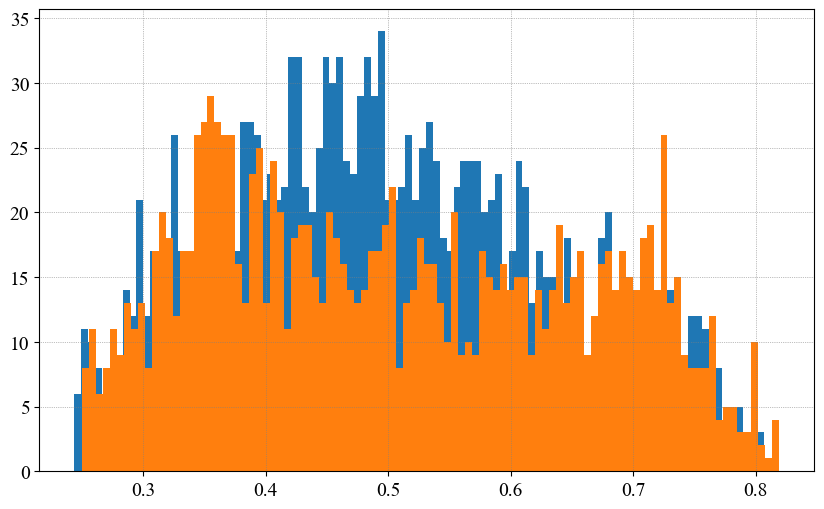

In [45]:
plt.hist(pred_train.pred, bins=100);
plt.hist(pred_test.pred, bins=100);

<AxesSubplot:xlabel='t'>

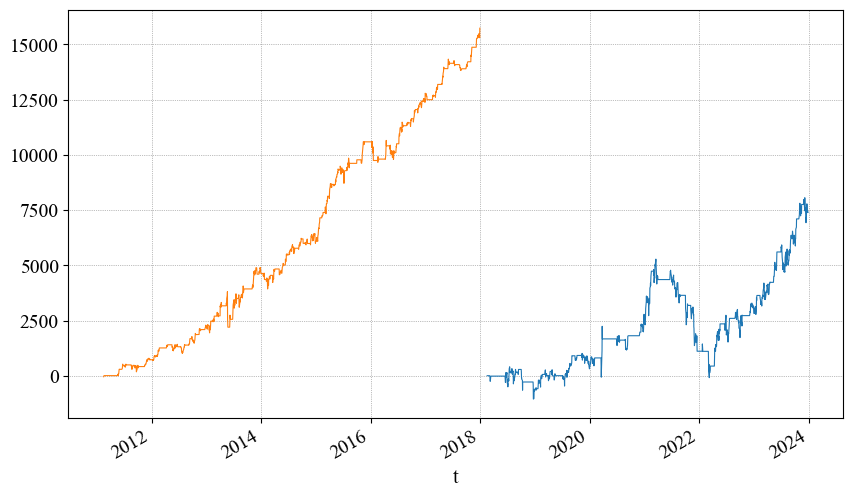

In [46]:
pred_test.assign(pl=lambda x: x.oc * (x.pred>0.5)).set_index("t").pl.cumsum().plot()
pred_train.assign(pl=lambda x: x.oc * (x.pred>0.5)).set_index("t").pl.cumsum().plot()

In [47]:
pred_test.assign(pl=lambda x: x.oc * (x.pred>0.5)).pl.describe()

count    1434.000000
mean        5.165641
std       140.360974
min      -789.970703
25%         0.000000
50%         0.000000
75%         0.612793
max      1099.830078
Name: pl, dtype: float64

<AxesSubplot:xlabel='date'>

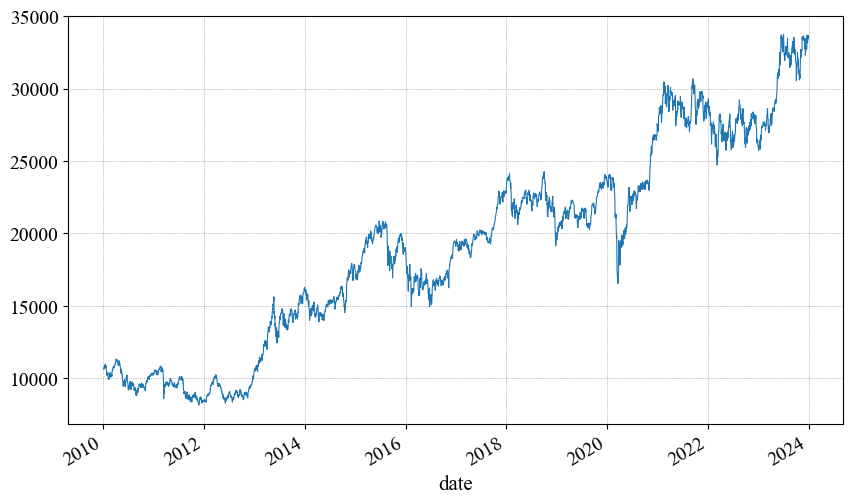

In [56]:
ohlc.query("ticker=='^N225'").close.plot()

# Evaluation

In [6]:
# !jupyter nbconvert Untitled.ipynb --to html --template lab --HTMLExporter.theme dark

[NbConvertApp] Converting notebook Untitled.ipynb to html
[NbConvertApp] Writing 660418 bytes to Untitled.html
